In [175]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import psycopg2
import networkx as nx

# Create a new dataframe to capture inter-departmental relationships based on prerequisites
Find dept code--> add it as a column, create another column listing the prereqs

- BIO, CS
- BIO, MATH
- CS, PHYS

In [145]:
dm = pd.read_json('/home/faculty/millbr02/pub/course_data.json')
dm['dept'] = dm.dept.map(lambda x : x[:-1])
dm.head()

,dept,description,gened,hours,number,prereq,title
0,accounting,A course specifically for students who have ha...,None,2 hours,ACCTG 110,"[First-year or sophomore st, ing]",Introduction to Accounting
1,accounting,The course provides a basic understanding of f...,None,4 hours,ACCTG 150,[ACCTG 110],Fundamentals of Accounting
10,accounting,,None,"1, 2, or 4 hours",ACCTG 485,[],Seminar
100,athletic-training,"This course will provide instruction, practice...",None,2 hours,ATHTR 468,"[ATHTR 465, senior st, ing]",Clinical VI: Advanced Health Care
101,athletic-training,,None,"1, 2, or 4 hours",ATHTR 490,[],Senior Project


### add department code to dm

In [146]:
dm['dept_code'] = dm.number.map(lambda x : x.split(' ')[0])
dm.head()

,dept,description,gened,hours,number,prereq,title,dept_code
0,accounting,A course specifically for students who have ha...,None,2 hours,ACCTG 110,"[First-year or sophomore st, ing]",Introduction to Accounting,ACCTG
1,accounting,The course provides a basic understanding of f...,None,4 hours,ACCTG 150,[ACCTG 110],Fundamentals of Accounting,ACCTG
10,accounting,,None,"1, 2, or 4 hours",ACCTG 485,[],Seminar,ACCTG
100,athletic-training,"This course will provide instruction, practice...",None,2 hours,ATHTR 468,"[ATHTR 465, senior st, ing]",Clinical VI: Advanced Health Care,ATHTR
101,athletic-training,,None,"1, 2, or 4 hours",ATHTR 490,[],Senior Project,ATHTR


### add prereq_code column to dm

In [147]:
code_list = set(list(dm.dept_code))

In [148]:
def get_prereq_code(x):
    prereqs = []
    for item in x:
        y = item.split(' ')
        for word in y:
            if word in code_list:
                prereqs.append(word)
    return prereqs

dm['prereq_code'] = dm.prereq.map(lambda x: get_prereq_code(x))
dm['prereq_course'] = dm.prereq.map(lambda x: re.findall(r'[A-Z]+ [0-9]+', str(x)))
dm

,dept,description,gened,hours,number,prereq,title,dept_code,prereq_code,prereq_course
0,accounting,A course specifically for students who have ha...,None,2 hours,ACCTG 110,"[First-year or sophomore st, ing]",Introduction to Accounting,ACCTG,[],[]
1,accounting,The course provides a basic understanding of f...,None,4 hours,ACCTG 150,[ACCTG 110],Fundamentals of Accounting,ACCTG,[ACCTG],[ACCTG 110]
10,accounting,,None,"1, 2, or 4 hours",ACCTG 485,[],Seminar,ACCTG,[],[]
100,athletic-training,"This course will provide instruction, practice...",None,2 hours,ATHTR 468,"[ATHTR 465, senior st, ing]",Clinical VI: Advanced Health Care,ATHTR,[ATHTR],[ATHTR 465]
101,athletic-training,,None,"1, 2, or 4 hours",ATHTR 490,[],Senior Project,ATHTR,[],[]
102,biology,"A study of relationships among insects, humans...",NWL,4 hours,BIO 112,[],"Insects, Humans and the Environment",BIO,[],[]
103,biology,A basic gross anatomy course including dissect...,NWL,4 hours,BIO 115,[],Human Anatomy,BIO,[],[]
104,biology,A survey of physiological systems and principl...,NWL,4 hours,BIO 116,[],Intro to Human Physiology,BIO,[],[]
105,biology,Genetics plays an ever increasing role in our ...,NWL,4 hours,BIO 125,[],Genetics and Society,BIO,[],[]
106,biology,Field study of the ecology of the arid Southwe...,NWL,4 hours,BIO 140,[],Introduction to Ecology of the Southwest,BIO,[],[]


### create new dataframe for dept_code and prereq_code

In [149]:
dept_code = list(dm.dept_code)
prereq_code = list(dm.prereq_code)

new_dept_code = []
new_prereq_code = []
new_prereq_course = []

major_place = 0
prereq_place = 0
for item in dm.prereq_course:
    course_place = 0
    for course in item:
        if len(item) > 1 and len(item) == len(prereq_code[prereq_place]):
            new_dept_code.append(dept_code[major_place])
            new_prereq_code.append(prereq_code[prereq_place][course_place])
            new_prereq_course.append(course)
            course_place += 1
        elif len(item) == 1 and len(prereq_code[prereq_place]) == 1:
            new_dept_code.append(dept_code[major_place])
            new_prereq_code.append(prereq_code[prereq_place][course_place])
            new_prereq_course.append(course)
            course_place += 1
    
    if len(item) == 0 and len(prereq_code[prereq_place]) > 0:
        for code in prereq_code[prereq_place]:
            new_dept_code.append(dept_code[major_place])
            new_prereq_code.append(code)
            new_prereq_course.append('')
        
    major_place += 1
    prereq_place += 1       
    
print(len(new_dept_code))
print(len(new_prereq_code))
print(len(new_prereq_course))

703
703
703


In [171]:
data = {'dept_code': new_dept_code, 
        'prereq_code': new_prereq_code,
       'prereq_course': new_prereq_course}
newDb = pd.DataFrame(data,columns=['dept_code','prereq_code','prereq_course'])
newDb = newDb.drop_duplicates()
newDb

,dept_code,prereq_code,prereq_course
0,ACCTG,ACCTG,ACCTG 110
1,ATHTR,ATHTR,ATHTR 465
2,BIO,BIO,BIO 151
4,BIO,BIO,BIO 152
5,BIO,CHEM,CHEM 152
6,BIO,CHEM,CHEM 201
7,BIO,PHYS,PHYS 152
27,AFRS,PAID,PAID 111
34,BIO,BIO,BIO 248
37,BIO,BIO,BIO 255


### single out non-prereq courses across different departments

In [167]:
major = []
prereq = []

place_major = 0
place_prereq = 0 

for i in range(len(new_dept_code)):
    if new_dept_code[i] != new_prereq_code[i]:
        major.append(new_dept_code[i])
        prereq.append(new_prereq_code[i])
    place_major += 1
    place_prereq += 1

print(len(major))
print(len(prereq))

208
208


### getting rid of duplicate columns

In [170]:
data = {'dept_code': new_dept_code, 
        'prereq_code': new_prereq_code,
       'prereq_course': new_prereq_course}
newDb = pd.DataFrame(data,columns=['dept_code','prereq_code','prereq_course'])
newDb.drop_duplicates()
newDb


finalData = {'dept_code': major,
             'prereq_code': prereq}

finalDb = pd.DataFrame(finalData,columns=['dept_code','prereq_code'])
finalDb = finalDb.drop_duplicates()
finalDb

,dept_code,prereq_code
0,BIO,CHEM
2,BIO,PHYS
3,AFRS,PAID
5,CHEM,BIO
6,CHEM,MATH
8,CHEM,PHYS
17,CLAS,PAID
21,COMS,WGST
23,CS,MATH
24,AFRS,SOC


# Find the non-prerequisite courses that may be required for a major. Add them as additional links


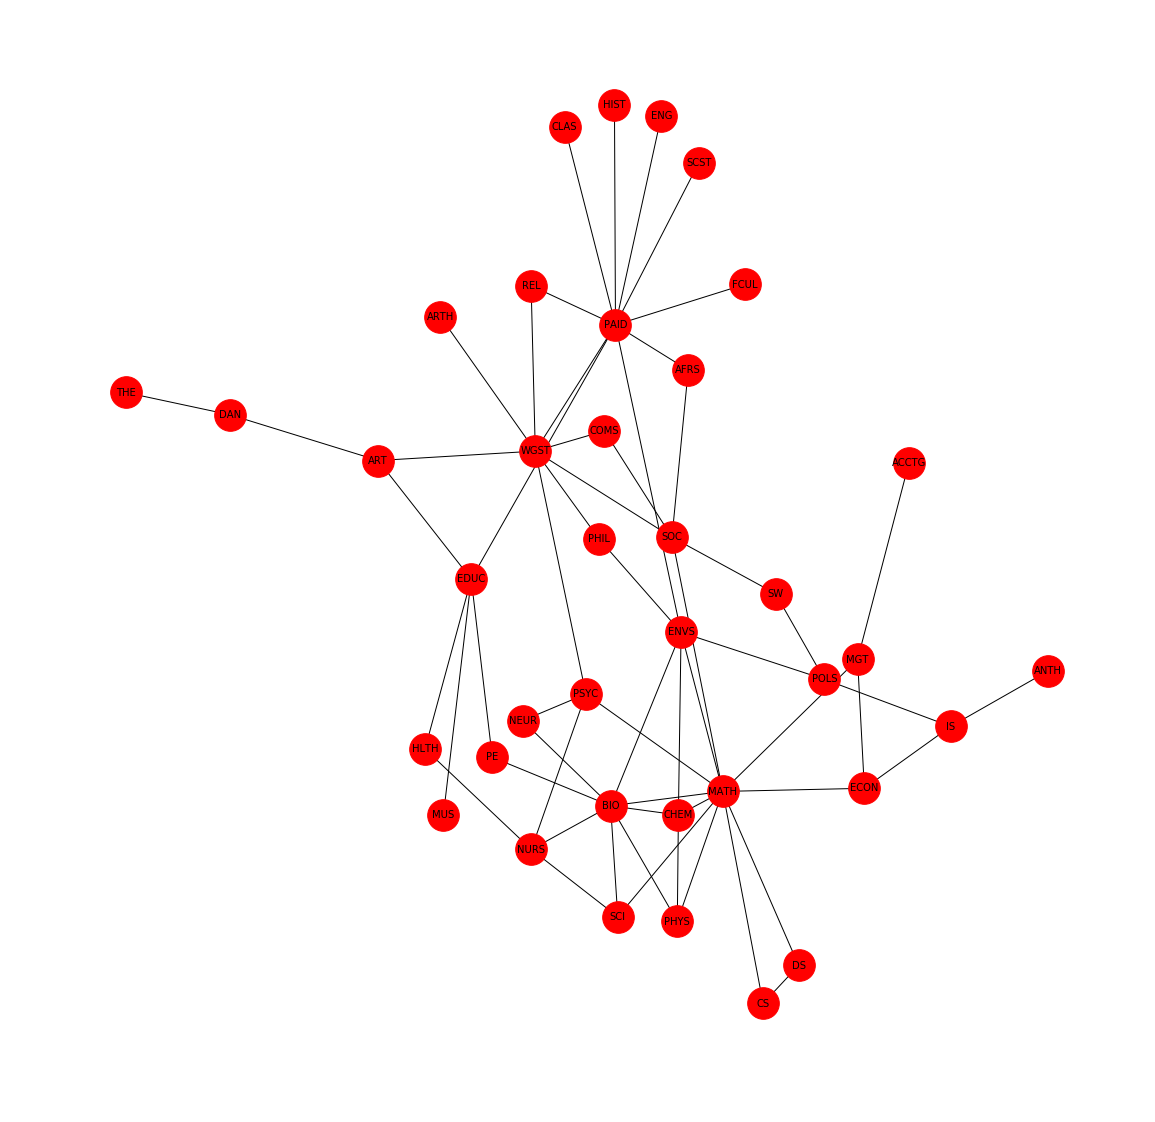

In [176]:
g = nx.Graph()

g.add_nodes_from(finalDb.dept_code)

for index, row in finalDb.iterrows():
    g.add_edge(row['dept_code'], row['prereq_code'])

gfig,gax = plt.subplots(figsize=(20,20))
pos = nx.spring_layout(g,k=.3,scale=8.0,center=(0,0))
nx.draw(g,pos,ax=gax,node_size=1000,with_labels=True,font_size=10)

plt.show()